In [86]:
from datetime import datetime

def xl_to_timestamp(dates, times):
    conv_datetime = []
    #split into MM/DD/YY
    for i in np.arange(dates.size):
        date = dates[i]
        time = times[i]
        date_split = date.split('/')
        year = int(date_split[2])
        month = int(date_split[0])
        day = int(date_split[1])
        time_split = time.split(':')
        hour = int(time_split[0])
        minute = int(time_split[1])
        second = int(time_split[2])

        conv_datetime.append(datetime(year, month, day, hour, minute, second).timestamp())
    return conv_datetime
    

,Date (MDY),Time,TEMPERTURE (Deg C),DateTime
0,7/28/2023,15:53:33,25.305,0.0
1,7/28/2023,15:54:03,25.242,30000.0
2,7/28/2023,15:54:33,25.163,60000.0
3,7/28/2023,15:55:03,25.081,90000.0
4,7/28/2023,15:55:33,25.022,120000.0
...,...,...,...,...
7851,7/31/2023,9:19:03,24.983,235530000.0
7852,7/31/2023,9:19:33,25.000,235560000.0
7853,7/31/2023,9:20:03,24.998,235590000.0
7854,7/31/2023,9:20:33,25.008,235620000.0


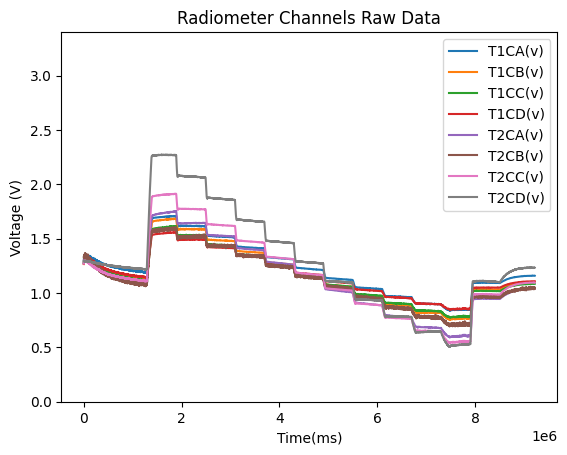

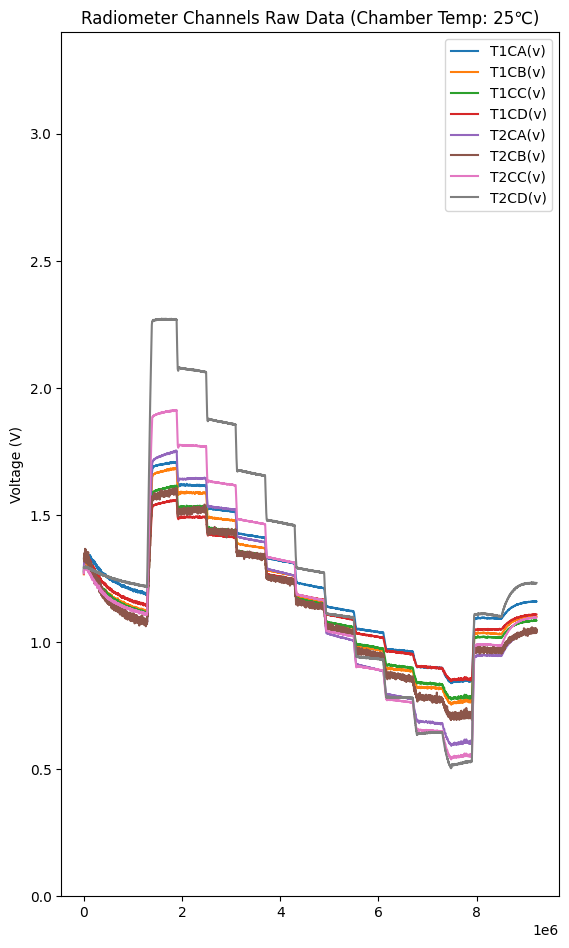

In [87]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from scipy.optimize import curve_fit


# -------------ADJUST FOR YOUR PROCEDURE------------------#

file_name = 'radiometer5_25_5-55_080923_sensor'
sensor_file = 'Data/' + file_name + '.csv'

#convert time colun to military time
chamber_file_name = 'radiometer2_wknd_5-55_072823_chamber_2'
chamber_file = 'Data/Chamber/' + chamber_file_name + '.csv'

offset = 60000 * 20 #value should be 60000 * minutes for how long the sensor was on before sweep
high_temp = 55
low_temp = 5
temp_interval = -5
temp_ranges = np.arange(high_temp, low_temp - abs(temp_interval), temp_interval) #range and interval of temperature steps
time_interval = 10 #minute length that each temperature is held

time_interval_ms = 60000 * time_interval #convert minutes to milliseconds
begin_cutoff = 60000 * 3#60000 * number of minutes to cut off from beginning of each temp
end_cutoff = 60000 * 3 #60000 * number of minutes to cut off from ending of each temp

chamber_temps = [25]
# -------------UNCOMMENT FOR PLOTTING BB TEMP------------------#
#bb_file = 'Data/radiometer1_30_5-55_061623_BB.txt'

# bb_df = pd.read_csv(bb_file) #read blackbody temperatures from text file
#bb_df.to_csv(r'Data/radiometer1_30_5-55_061623_BB.csv', index = None)

#bb_df.columns = ['BB Temp']
#display(bb_df)
# -------------UNCOMMENT FOR PLOTTING BB TEMP------------------#

data = pd.read_csv(sensor_file)
if not os.path.exists('Reports/' + file_name):
     os.mkdir('Reports/' + file_name)
for temp in chamber_temps:
     if not os.path.exists('Reports/' + file_name + '/' + str(temp)):
          os.mkdir('Reports/' + file_name + '/' + str(temp))
     
channel_col = []
internal_col = []
nums = [1,2]
channels = ['A', 'B', 'C', 'D']
for num in nums:
     for chan in channels:
          channel_col.append("T" + str(num) + "C" + str(chan) + "(v)")
     internal_col.append("T" + str(num) +"Therm(c)")

data_actual_cham = pd.read_csv(chamber_file)
columns_to_keep = ['Date (MDY)', 'Time', 'TEMPERTURE (Deg C)']
data_actual_cham = data_actual_cham[columns_to_keep]
data_actual_cham['DateTime'] = xl_to_timestamp(data_actual_cham['Date (MDY)'], data_actual_cham['Time'])
data_actual_cham['DateTime'] -= data_actual_cham['DateTime'].iloc[0]
data_actual_cham['DateTime'] *= 1000
data_actual_cham.to_csv('testdatetime.csv')
# -------------UNCOMMENT FOR ROLLING WINDOW------------------#
window_size = 300
"""#window = scipy.signal.gaussian(M=30, std=6)
#smoothed = np.convolve(data[channel_col], window, mode='valid')
data_rolling = data[channel_col].rolling(window_size).mean()
#data_rolling = smoothed

data_rolling.insert(loc = 0,
     column = "Time(ms)",
     value = data["Time(ms)"])
data_rolling.drop(data_rolling.index[:window_size], inplace=True)
#display(data_rolling)
plt.figure()
data_rolling.plot(x = "Time(ms)", y = channel_col)
data = data_rolling """

# -------------UNCOMMENT FOR ROLLING WINDOW------------------#     

#channel_col.remove("T2CA(v)") #used to remove clipping channel
#channel_col.remove("T2CB(v)") #used to remove clipping channel
#data[(data["Time(ms)"] > (offset + time_interval_ms * 4)) & (data["Time(ms)"] < (offset + time_interval_ms * 7))].plot(x = "Time(ms)", y = channel_col)
data[(data["Time(ms)"] > (0))].plot(x = "Time(ms)", y = channel_col)
plt.title("Radiometer Channels Raw Data")
plt.ylim([0, 3.4])
plt.ylabel("Voltage (V)")

plt.figure()
i = 1
chamb_interval = 60000 * 720
chamb_start = 0

data_chamber_temps = []
for cham in chamber_temps:
     plt.subplot(1,3, i)
     data_cham = data[(data["Time(ms)"] > (chamb_start)) & (data["Time(ms)"] < (chamb_start + chamb_interval))]
     #data[(data["Time(ms)"] > (chamb_start)) & (data["Time(ms)"] < (chamb_start + chamb_interval))].plot(x = "Time(ms)", y = channel_col)
     plt.plot(data_cham.loc[:,"Time(ms)"], data_cham.loc[:,channel_col])
     plt.legend(channel_col, fontsize = 10)
     plt.title("Radiometer Channels Raw Data (Chamber Temp: " + str(cham) + "\N{DEGREE CELSIUS})")
     plt.ylim([0, 3.4])
     plt.ylabel("Voltage (V)")
     i += 1
     chamb_start += chamb_interval
     data_chamber_temps.append(data_cham)
     
plt.subplots_adjust(left=0.1, right=2.9, bottom=0.1, top=1.9, wspace=0.3, hspace=1)
plt.savefig('Reports/' + file_name + '/raw_data_' + file_name + '.png', bbox_inches='tight')

""" #plot internals
plt.figure()
#data[data["Time(ms)"] > (0)].plot(x = "Time(ms)", y = internal_col)
plt.ylim([0, 3.4])
plt.plot(data.loc[:,"Time(ms)"], data[internal_col])
plt.ylabel("Temp (C)")
plt.title("Internal Temperatures") """

display(data_actual_cham)


Segment the data into different BB temps

In [88]:
#segment the data into the different BB temps
raw_cleaned_df = pd.DataFrame()
raw_averaged_cleaned_df = pd.DataFrame()
chamber_temp_dicts = []
lower_bound = offset #time after s

for chamber_temp in chamber_temps:
    temp_dict = {}
    averaged_temp_dict = {}
    #lower_bound += time_interval_ms #ignore the first interval (25C before the sweep)
    #create dictionary of dataframes, cutoff 5 minutes from begininng and half a minute from the end to obtain stabilized temp
    for i in range(0, temp_ranges.size): 
        temp_dict[str(temp_ranges[i])] = data[(data["Time(ms)"] > (lower_bound+begin_cutoff)) & (data["Time(ms)"] < (lower_bound + time_interval_ms-end_cutoff))]
        temp_dict[str(temp_ranges[i])].insert(loc = 1,
            column = "BB Temp",
            value = temp_ranges[i])
        
        #copy segmented temperature, perform rolling mean
        temp_dict_copy = temp_dict[str(temp_ranges[i])].copy()
        averaged_temp_dict[str(temp_ranges[i])] = temp_dict_copy[channel_col + internal_col].rolling(window_size).mean()

        #re-add BB temp and time
        averaged_temp_dict[str(temp_ranges[i])].insert(loc = 0,
            column = "BB Temp",
            value = temp_ranges[i])
        averaged_temp_dict[str(temp_ranges[i])].insert(loc = 0,
            column = "Time(ms)",
            value = data["Time(ms)"])
        
        #drop the first few samples not in window
        averaged_temp_dict[str(temp_ranges[i])].drop(averaged_temp_dict[str(temp_ranges[i])].index[:window_size], inplace=True)
        lower_bound += time_interval_ms

    chamber_temp_dicts.append(temp_dict)
    raw_cleaned_df = pd.concat(list(temp_dict.values()))
    raw_cleaned_df.to_csv('Reports/' + file_name + '/' + str(chamber_temp) + '/' + str(chamber_temp) + '_raw_cleaned_' + file_name + '.csv')

    raw_averaged_cleaned_df = pd.concat(list(averaged_temp_dict.values()))
    raw_averaged_cleaned_df.to_csv('Reports/' + file_name + '/' + str(chamber_temp) + '/' + str(chamber_temp) + '_raw_averaged_cleaned_' + file_name + '.csv')

   

display(raw_cleaned_df)



,Time(ms),BB Temp,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T1Therm(c),T2CA(v),T2CB(v),T2CC(v),T2CD(v),T2Therm(c)
1221,1380120,55,1.633790,1.601236,1.540777,1.492849,25.099962,1.650231,1.534328,1.828713,2.212150,24.245277
1222,1381249,55,1.640452,1.607757,1.547235,1.497580,25.101250,1.657049,1.550707,1.837246,2.221175,24.246571
1223,1382378,55,1.646526,1.615550,1.553619,1.502745,25.101618,1.664233,1.540881,1.845071,2.231477,24.247395
1224,1383507,55,1.651406,1.620921,1.558284,1.506451,25.102476,1.671347,1.542099,1.852427,2.242695,24.248042
1225,1384636,55,1.656675,1.625994,1.563269,1.510210,25.103273,1.677788,1.548719,1.859621,2.247699,24.249042
...,...,...,...,...,...,...,...,...,...,...,...,...
6740,7614814,5,0.844241,0.761316,0.779318,0.852135,28.836768,0.599818,0.706609,0.548407,0.519804,27.988239
6741,7615943,5,0.843914,0.760620,0.778996,0.851573,28.837685,0.599446,0.714542,0.547474,0.519666,27.988838
6742,7617072,5,0.843776,0.760330,0.779099,0.850773,28.838088,0.599658,0.707158,0.547791,0.520003,27.989190
6743,7618201,5,0.844206,0.760649,0.779041,0.851579,28.838785,0.601191,0.719912,0.549769,0.520156,27.989824


Plot the sensor readings at different blackbody temperatures

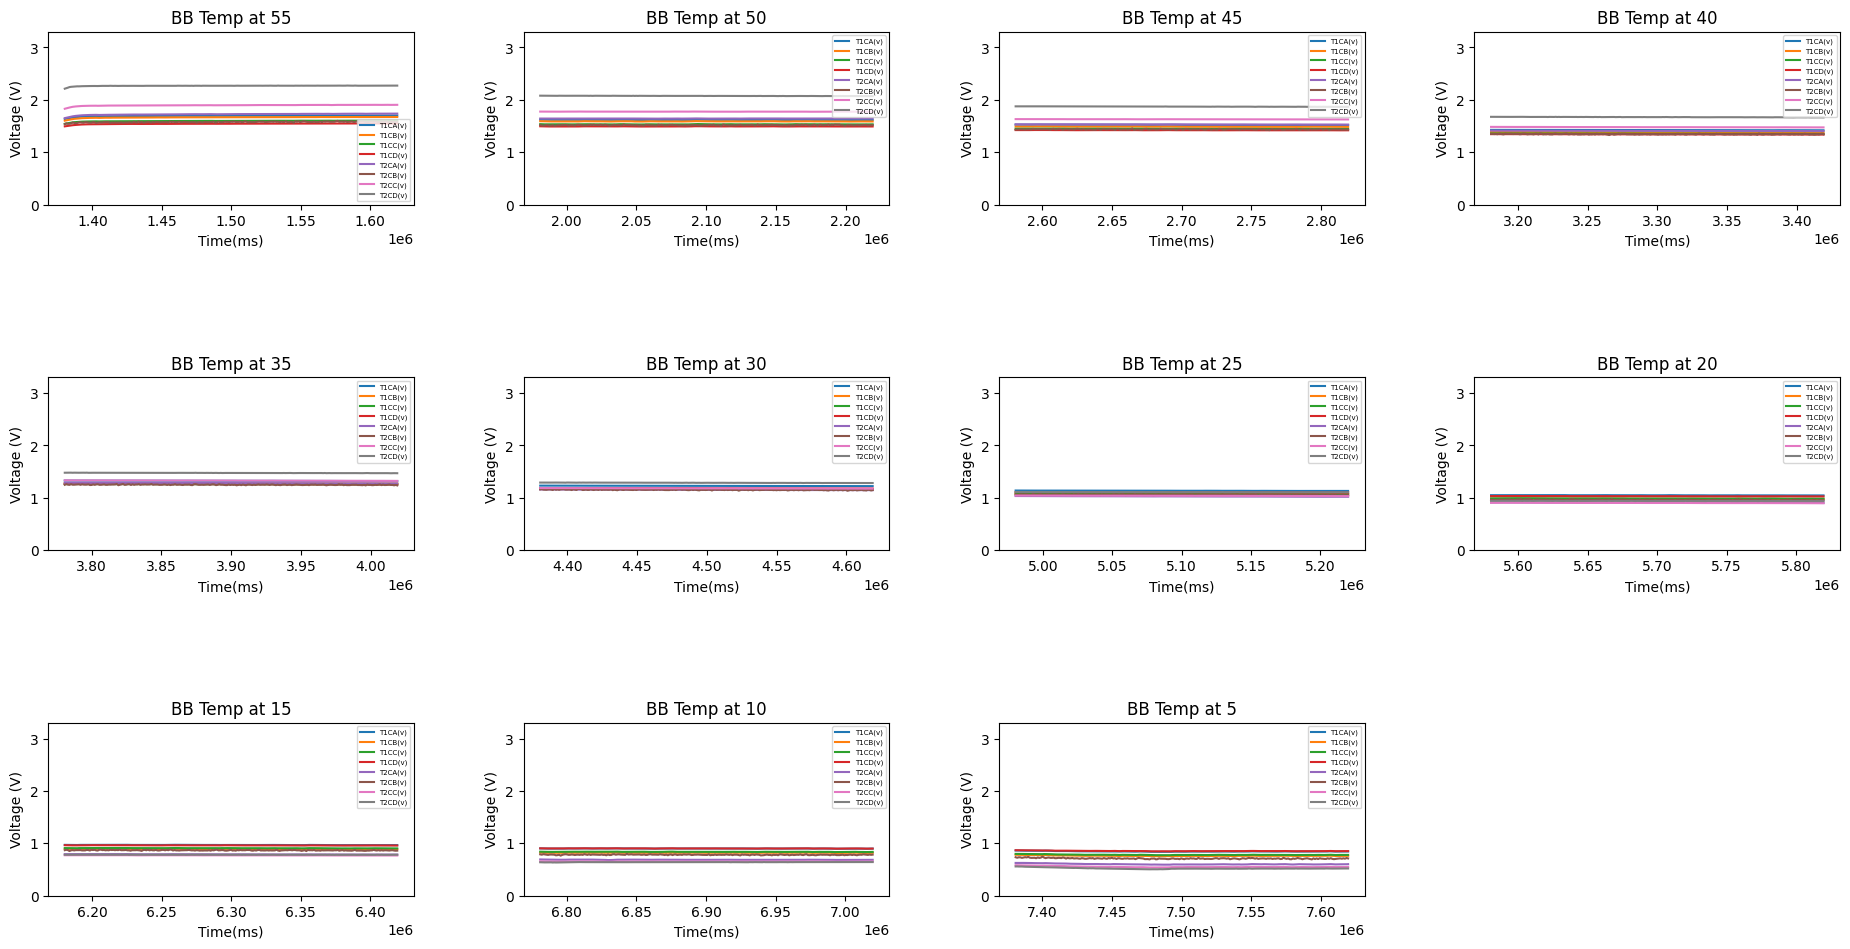

,Time(ms),BB Temp,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T1Therm(c),T2CA(v),T2CB(v),T2CC(v),T2CD(v),T2Therm(c)
Chamber: 25 Max at 55,1619580.0,55.0,1.700892,1.673479,1.604449,1.549137,25.298423,1.736078,1.597891,1.904065,2.272038,24.472280
Chamber: 25 VPP55,239460.0,0.0,0.067103,0.072243,0.063672,0.056288,0.198461,0.085847,0.063562,0.075352,0.059888,0.227003
Chamber: 25 Max at 50,2219424.0,50.0,1.622373,1.592425,1.536812,1.495493,25.980098,1.644524,1.528796,1.775477,2.078664,25.129535
Chamber: 25 VPP50,238338.0,0.0,0.007916,0.008350,0.008328,0.006435,0.310013,0.004882,0.029834,0.004502,0.009473,0.263521
Chamber: 25 Max at 45,2819310.0,45.0,1.525559,1.490555,1.449350,1.423349,26.664645,1.533955,1.452971,1.632491,1.876917,25.854487
Chamber: 25 VPP45,238348.0,0.0,0.007758,0.007925,0.007132,0.006570,0.242438,0.007952,0.032846,0.008690,0.012098,0.293553
Chamber: 25 Max at 40,3419182.0,40.0,1.426244,1.385077,1.356525,1.343966,27.255723,1.412173,1.357214,1.482774,1.675057,26.439498
Chamber: 25 VPP40,238347.0,0.0,0.008857,0.008522,0.007864,0.008065,0.194827,0.010577,0.030803,0.009991,0.011563,0.245404
Chamber: 25 Max at 35,4019017.0,35.0,1.328602,1.280577,1.263654,1.265116,27.748101,1.285574,1.263505,1.332827,1.479405,26.891149
Chamber: 25 VPP35,238360.0,0.0,0.009522,0.009526,0.009389,0.009012,0.185338,0.011941,0.027783,0.010753,0.011328,0.158264


In [89]:
temp_max_min = pd.DataFrame()

#specific_temp_dict = ['35', '30', '25'], for when you want to look at specific temps
for temp_dict in chamber_temp_dicts:
    plt.figure()
    i = 1
    chamber_temp = chamber_temps[i - 1]
    for key in temp_dict:
        plt.subplot(3, 4, i)
        plt.subplots_adjust(left=0.1, right=2.9, bottom=0.1, top=1.9, wspace=0.3, hspace=1)
        plt.plot(temp_dict[key].loc[:,"Time(ms)"], temp_dict[key].loc[:,channel_col])
        plt.title("BB Temp at " + key)
        plt.ylabel("Voltage (V)")
        plt.ylim([0, 3.3])
        plt.xlabel("Time(ms)")
        plt.legend(channel_col, fontsize = 5)
        i += 1
        max_temp = temp_dict[key].max() #get max temps
        max_temp_df = pd.DataFrame({'Chamber: ' + str(chamber_temp) + ' Max at ' + str(key): max_temp}).T

        min_temp = temp_dict[key].min() #get min temps 
        min_temp_df = pd.DataFrame({'Chamber: ' + str(chamber_temp) + ' Min at ' + str(key): min_temp}).T

        vpp = max_temp - min_temp #calculate peak-to-peak
        vpp_df = pd.DataFrame({'Chamber: ' + str(chamber_temp) + ' VPP' + str(key): vpp}).T
        temp_max_min= pd.concat([temp_max_min, max_temp_df, vpp_df]) #transpose
        plt.savefig('Reports/' + file_name + '/' + str(chamber_temp) + '/' + str(chamber_temp) + '_segmented_temp_voltages_' + file_name + '.png', bbox_inches='tight')


plt.show()
display(temp_max_min) #plot segmented temp data

In [90]:
#create histograms for each channel
""" for key in temp_dict:
    plt.figure()
    temp = temp_dict[key]
    i = 1
    for chan in channel_col:
        plt.subplot(2, 4, i)
        plt.hist(temp[chan], bins=30, density=True, alpha=0.6, color='g')
        plt.title(chan)
        i += 1 """

" for key in temp_dict:\n    plt.figure()\n    temp = temp_dict[key]\n    i = 1\n    for chan in channel_col:\n        plt.subplot(2, 4, i)\n        plt.hist(temp[chan], bins=30, density=True, alpha=0.6, color='g')\n        plt.title(chan)\n        i += 1 "

In [91]:
#calculate averages, std devs and rms values
chamber_ch_avgs = []
#chamber_ch_std_dev = []
#chamber_ch_sensitivity = []
temp_index = 0
for temp_dict in chamber_temp_dicts:
    ch_avgs = pd.DataFrame()
    ch_std_dev = pd.DataFrame()
    ch_sensitivity = pd.DataFrame()
    ch_rms = pd.DataFrame()
    for key in temp_dict:
        temps = temp_dict[key]
        ch_avgs[key] = temps[channel_col].mean()
        ch_std_dev[key] = temps[channel_col].std()
        ch_rms[key]  = np.sqrt((temps[channel_col] ** 2).mean())
    ch_avgs=ch_avgs.T
    ch_avgs.insert(loc = 0,
            column = 'BB Temp',
            value = temp_ranges)
    ch_std_dev =ch_std_dev.T
    ch_std_dev.insert(loc = 0,
            column = 'BB Temp',
            value = temp_ranges)

    ch_rms =ch_rms.T
    ch_rms.insert(loc = 0,
            column = 'BB Temp',
            value = temp_ranges)

    i = 0
    for temp in temp_ranges:
        if not (i == 0):
            ch_sensitivity[str(temp_ranges[i-1]) + "to" + str(temp_ranges[i])] = (ch_avgs.iloc[i] - ch_avgs.iloc[i-1])/ temp_interval
        i += 1
    ch_sensitivity.drop(index=ch_sensitivity.index[0], axis=0, inplace=True)
    ch_sensitivity = ch_sensitivity.T
    avg_sensitivity = ch_sensitivity.mean().mean()
    print("Average sensitivity: " + str(avg_sensitivity))
    avg_std_dev = ch_std_dev[channel_col].mean().mean()
    print("Average Std. Dev: " + str(avg_std_dev))
    snr = avg_sensitivity / avg_std_dev
    print("SNR: " + str(snr))

    #display(ch_avgs) #display statistics
    #display(ch_std_dev)
    #display(ch_sensitivity)
        #display(ch_rms)
    ch_avgs.to_csv('Reports/' + file_name + '/' + str(chamber_temps[temp_index]) + '/' + str(chamber_temps[temp_index]) + '_voltage_avg_' + file_name + '.csv')
    ch_std_dev.to_csv('Reports/' + file_name + '/' + str(chamber_temps[temp_index]) + '/' + str(chamber_temps[temp_index]) + '_voltage_std_dev_' + file_name + '.csv')
    ch_sensitivity.to_csv('Reports/' + file_name + '/' + str(chamber_temps[temp_index]) + '/' + str(chamber_temps[temp_index]) + '_voltage_sens_' + file_name + '.csv')

    temp_index += 1
    chamber_ch_avgs.append(ch_avgs)

# -------------UNCOMMENT FOR PLOT OF AVERAGE VOLTAGE VS. BB TEMP------------------#
""" plt.plot(ch_avgs.loc[:,"Temp"], ch_avgs.loc[:,channel_col], marker = '.')
plt.legend(channel_col, fontsize = 5)
plt.xlabel("Temp (\N{DEGREE CELSIUS})")
plt.ylabel("Average Voltage (V)")
plt.title("Avg. Voltage vs. Blackbody Temperature")
plt.savefig('Reports/' + file_name + '/' + 'avg_voltage_' + file_name + '.png', bbox_inches='tight') """
# -------------UNCOMMENT FOR PLOT OF AVERAGE VOLTAGE VS. BB TEMP------------------#
#ch_rms.to_csv('Reports/' + file_name + '/voltage_std_dev.csv')

Average sensitivity: 0.020798437813104018
Average Std. Dev: 0.0037895804909570258
SNR: 5.488321956146537


' plt.plot(ch_avgs.loc[:,"Temp"], ch_avgs.loc[:,channel_col], marker = \'.\')\nplt.legend(channel_col, fontsize = 5)\nplt.xlabel("Temp (℃)")\nplt.ylabel("Average Voltage (V)")\nplt.title("Avg. Voltage vs. Blackbody Temperature")\nplt.savefig(\'Reports/\' + file_name + \'/\' + \'avg_voltage_\' + file_name + \'.png\', bbox_inches=\'tight\') '

In [92]:
#Planck Radiance
def planck_radiance(wavelength, temperature):
    h = 6.62607015e-34  # Planck's constant
    c = 299792458  # Speed of light
    k = 1.38064852e-23  # Boltzmann constant

    #convert celsius to Kelvin
    temperature += 273.15
    
    numerator = 2 * h * c ** 2
    denominator = wavelength ** 5 * (np.exp((h * c) / (wavelength * k * temperature)) - 1)
    radiance = numerator / denominator
    return radiance

def linear_fit(x, slope , b):
    return slope * x + b

def quadratic_fit(x, a, b, c):
    return a * (x ** 2) + b * x + c

def gaussian_fit(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

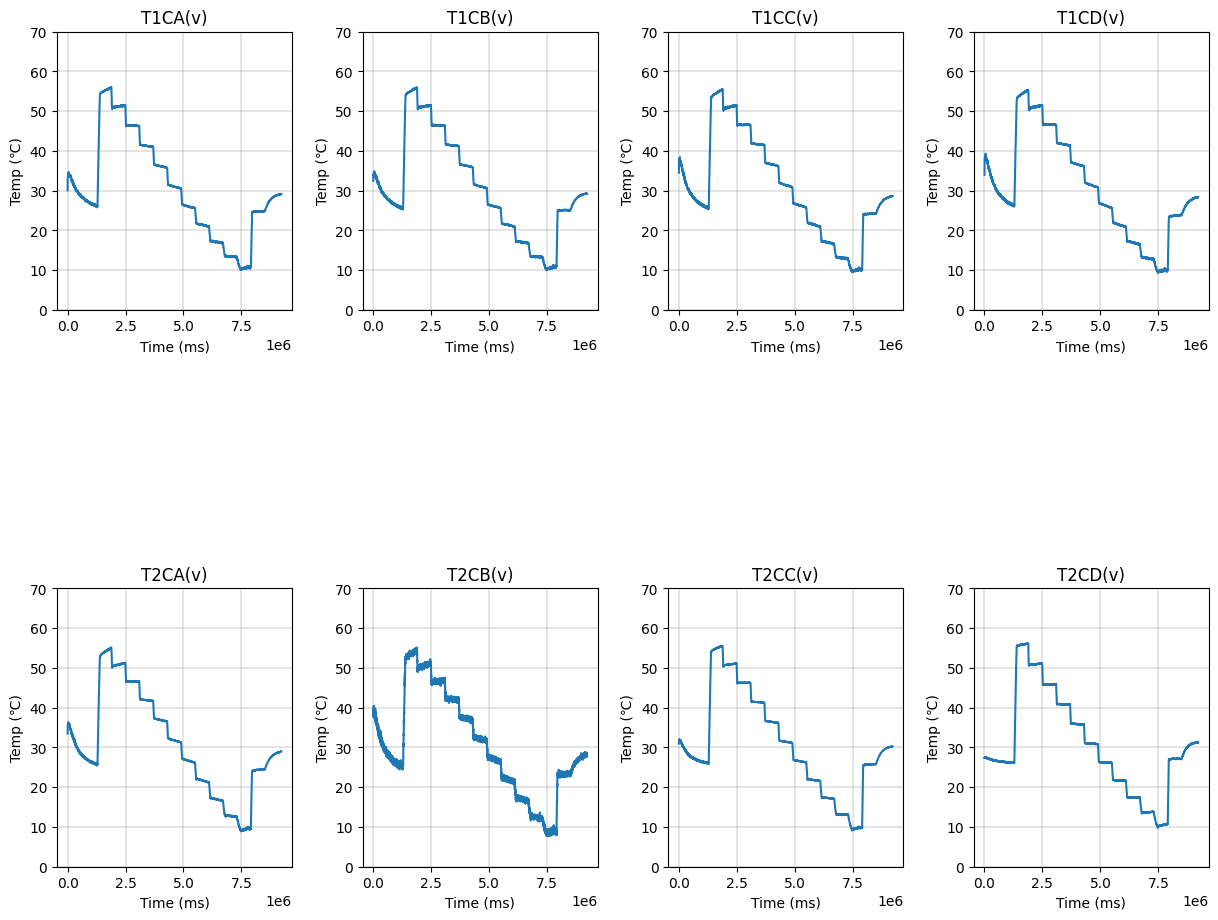

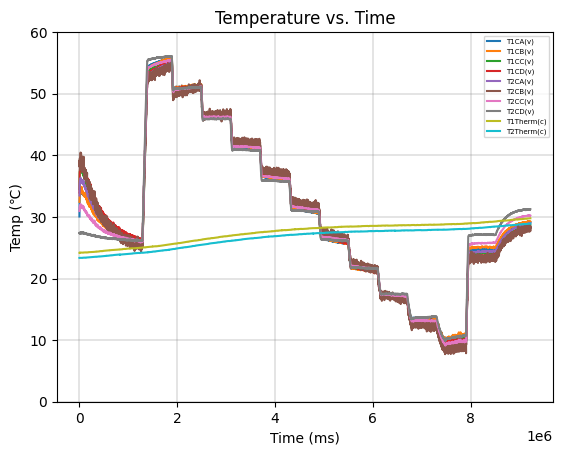

' #Plot error\nplt.figure()\nlower_bound = offset\n#display(data_temp)\nfor i in range(0, bb_df[\'BB Temp\'].size):\n    bb_temp = bb_df[\'BB Temp\']\n    data_temp_interval = data_temp[(data_temp["Time(ms)"] > (lower_bound)) & (data_temp["Time(ms)"] < (lower_bound + time_interval_ms))]\n    #display(data_temp_interval)\n    temp_error = pd.concat([temp_error, ((abs((data_temp_interval[channel_col] - bb_temp[i])/bb_temp[i])) * 100)]) #convert the voltage to a temp and calculate percent error\n    lower_bound += time_interval_ms\ntemp_times = data_temp[(data_temp["Time(ms)"] > (1200000)) & (data_temp["Time(ms)"] < (lower_bound))]["Time(ms)"]\ntemp_error.insert(loc = 0,column = \'Time(ms)\', value = temp_times)\n\nfor ch in channel_col:\n    plt.plot(temp_error["Time(ms)"], temp_error[ch])\n\nplt.xlabel("Time (ms)")\nplt.ylabel("Percent Error (%)")\nplt.title("Temperature Percent Error vs. Time")\nplt.grid(color=\'gray\', linestyle=\'-\', linewidth=0.3)\nplt.legend(channel_col, fontsize 

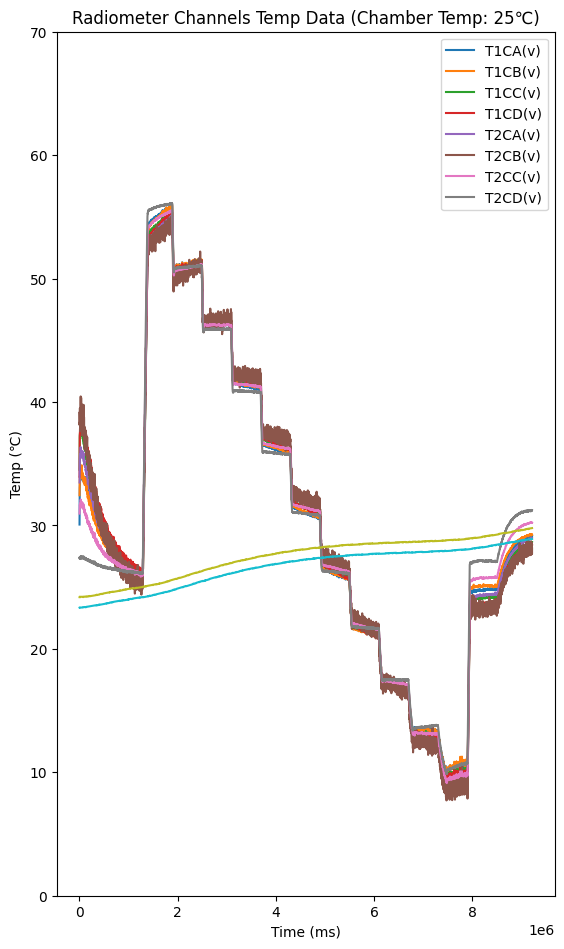

In [99]:
#obtain curves for data
temp_popt = {}
temp_pcov = {}

combined_data_temp = pd.DataFrame()
#fig, ax = plt.subplots(figsize = (10, 5))
bb_index = np.arange(1.2e6,8.4e6,0.6e6)

sensor_1_chans = channel_col[0:3]
sensor_2_chans = channel_col[4:7]

temp_index = 0
for data_to_convert in data_chamber_temps:
    data_temp = data_to_convert.copy()
    #temp_error = pd.DataFrame()
    plt.figure()
    i = 1
    ch_avg = chamber_ch_avgs[temp_index]
    for chan in channel_col:
        #apply linear fit for each channel
        temp_popt[chan], temp_pcov[chan] = curve_fit(linear_fit, ch_avg[chan], ch_avg["BB Temp"])
        calc_temp = linear_fit(data[chan], *temp_popt[chan])
        data_temp[chan] = calc_temp
        ax = plt.subplot(3, 4, i)
        plt.subplots_adjust(left=0.1, right=1.9, bottom=0.1, top=3, wspace=0.3, hspace=1)
        
         #attempt to flatten by adding/subtracting difference between starting and current internal of each time frame
        if (chan in sensor_1_chans):
            internal = 'T1Therm(c)'
        else:
            internal = 'T2Therm(c)' 

        diff_factor = 1

        internal_temp = data_temp[internal]
        internal_temp_diff = internal_temp - internal_temp.iloc[30*60]
        data_temp[chan] = data_temp[chan] + (diff_factor * internal_temp_diff)
        #try matching chamber and internal temperature
        #plt.plot(data["Time(ms)"], calc_temp)
        plt.plot(data_temp.loc[:,"Time(ms)"], data_temp[chan])
        plt.xlabel("Time (ms)")
        plt.ylabel("Temp (\N{DEGREE CELSIUS})")
        plt.title(chan)
        plt.grid(color='gray', linestyle='-', linewidth=0.3)
        plt.ylim((temp_ranges.min() - 5,temp_ranges.max() + 15))
        i += 1
    plt.savefig('Reports/' + file_name + '/' + str(chamber_temps[temp_index]) + '/' + str(chamber_temps[temp_index]) + '_indiv_channel_temps_' + file_name + '.png', bbox_inches='tight')    
    temp_index += 1
    combined_data_temp = pd.concat([combined_data_temp, data_temp])

combined_data_temp.to_csv('Reports/' + file_name + '/' + 'converted_temps_' + file_name + '.csv')
plt.show()

#plot temp data for entire capture
plt.figure()
for chan in channel_col:
    plt.plot(combined_data_temp["Time(ms)"], combined_data_temp[chan])
    plt.xlabel("Time (ms)")
    plt.ylabel("Temp (\N{DEGREE CELSIUS})")
    plt.title("Temperature vs. Time")
    plt.grid(color='gray', linestyle='-', linewidth=0.3)
    
    plt.ylim((temp_ranges.min() - 5,temp_ranges.max() + 5))
    #plt.scatter(bb_index, bb_df['BB Temp'])
plt.plot(data["Time(ms)"], data[internal_col])
#plt.plot(data_actual_cham["DateTime"], data_actual_cham['TEMPERTURE (Deg C)'])
plt.legend(channel_col + internal_col + ["Chamber Temp"], fontsize = 5)
plt.savefig('Reports/' + file_name + '/' + 'temps_' + file_name + '.png', bbox_inches='tight')
plt.show()


plt.figure()
i = 1
chamb_interval = 60000 * 720
chamb_start = 0

conv_data_chamber_temps = [] #list of dataframes for each chamber temp, in units of C
for cham in chamber_temps:
     plt.subplot(1,3, i)
     data_temp_cham = combined_data_temp[(combined_data_temp["Time(ms)"] > (chamb_start)) & (combined_data_temp["Time(ms)"] < (chamb_start + chamb_interval))]
     #data[(data["Time(ms)"] > (chamb_start)) & (data["Time(ms)"] < (chamb_start + chamb_interval))].plot(x = "Time(ms)", y = channel_col)
     
    

     plt.plot(data_temp_cham.loc[:,"Time(ms)"], data_temp_cham.loc[:,channel_col])
     plt.plot(data_temp_cham.loc[:,"Time(ms)"], data_temp_cham.loc[:,internal_col])
     plt.legend(channel_col, fontsize = 10)
     plt.title("Radiometer Channels Temp Data (Chamber Temp: " + str(cham) + "\N{DEGREE CELSIUS})")
     plt.xlabel("Time (ms)")
     plt.ylabel("Temp (\N{DEGREE CELSIUS})")
     plt.ylim((temp_ranges.min() - 5,temp_ranges.max() + 15))
     i += 1
     chamb_start += chamb_interval
     conv_data_chamber_temps.append(data_cham)
     
plt.subplots_adjust(left=0.1, right=2.9, bottom=0.1, top=1.9, wspace=0.3, hspace=1)
plt.savefig('Reports/' + file_name + '/temps_indiv_chamber' + file_name + '.png', bbox_inches='tight')
# -------------UNCOMMENT FOR ERROR CALC, REQUIRES BB TEMPS------------------#
""" #Plot error
plt.figure()
lower_bound = offset
#display(data_temp)
for i in range(0, bb_df['BB Temp'].size):
    bb_temp = bb_df['BB Temp']
    data_temp_interval = data_temp[(data_temp["Time(ms)"] > (lower_bound)) & (data_temp["Time(ms)"] < (lower_bound + time_interval_ms))]
    #display(data_temp_interval)
    temp_error = pd.concat([temp_error, ((abs((data_temp_interval[channel_col] - bb_temp[i])/bb_temp[i])) * 100)]) #convert the voltage to a temp and calculate percent error
    lower_bound += time_interval_ms
temp_times = data_temp[(data_temp["Time(ms)"] > (1200000)) & (data_temp["Time(ms)"] < (lower_bound))]["Time(ms)"]
temp_error.insert(loc = 0,column = 'Time(ms)', value = temp_times)

for ch in channel_col:
    plt.plot(temp_error["Time(ms)"], temp_error[ch])

plt.xlabel("Time (ms)")
plt.ylabel("Percent Error (%)")
plt.title("Temperature Percent Error vs. Time")
plt.grid(color='gray', linestyle='-', linewidth=0.3)
plt.legend(channel_col, fontsize = 5)
plt.scatter(bb_index, bb_df['BB Temp'])
display(temp_error)
plt.plot(data["Time(ms)"], linear_fit(data["T2CD(v)"], *temp_popt["T2CD(v)"]))
plt.plot(data["T1CB(v)"], linear_fit(data["T1CB(v)"], *temp_popt["T1CB(v)"])) """
# -------------UNCOMMENT FOR ERROR CALC, REQUIRES BB TEMPS------------------#


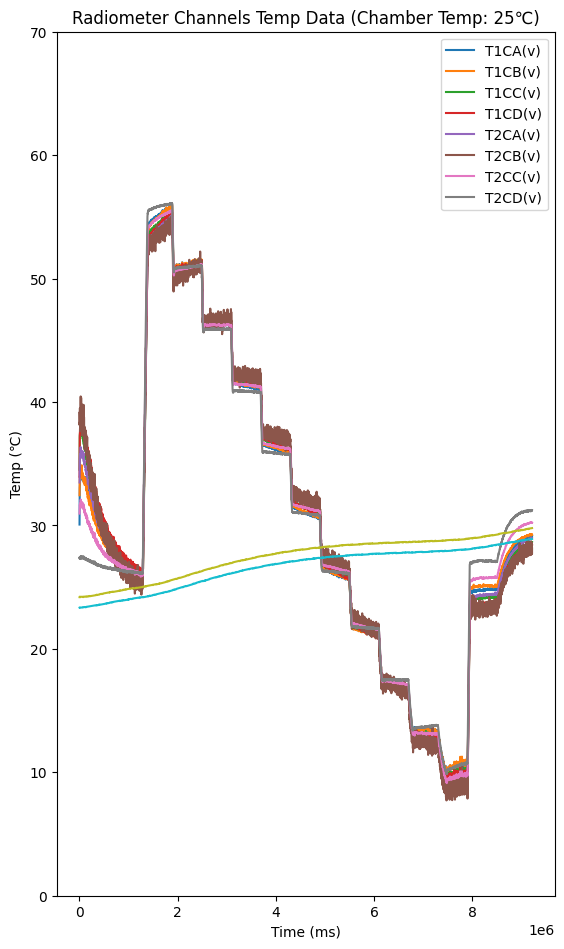

In [94]:
plt.figure()
i = 1
chamb_interval = 60000 * 720
chamb_start = 0

for chan in channel_col:
     #attempt to flatten by adding/subtracting difference between starting and current internal of each time frame
     if (chan in sensor_1_chans):
          internal = 'T1Therm(c)'
     else:
          internal = 'T2Therm(c)' 
     internal_temp = data_temp[internal]
     internal_temp_diff = internal_temp - internal_temp.iloc[30*60]
     data_temp[chan] = data_temp[chan] + internal_temp_diff

conv_data_chamber_temps = [] #list of dataframes for each chamber temp, in units of C
for cham in chamber_temps:
     plt.subplot(1,3, i)
     data_temp_cham = combined_data_temp[(combined_data_temp["Time(ms)"] > (chamb_start)) & (combined_data_temp["Time(ms)"] < (chamb_start + chamb_interval))]
     #data[(data["Time(ms)"] > (chamb_start)) & (data["Time(ms)"] < (chamb_start + chamb_interval))].plot(x = "Time(ms)", y = channel_col)
     
    

     plt.plot(data_temp_cham.loc[:,"Time(ms)"], data_temp_cham.loc[:,channel_col])
     plt.plot(data_temp_cham.loc[:,"Time(ms)"], data_temp_cham.loc[:,internal_col])
     plt.legend(channel_col, fontsize = 10)
     plt.title("Radiometer Channels Temp Data (Chamber Temp: " + str(cham) + "\N{DEGREE CELSIUS})")
     plt.xlabel("Time (ms)")
     plt.ylabel("Temp (\N{DEGREE CELSIUS})")
     plt.ylim((temp_ranges.min() - 5,temp_ranges.max() + 15))
     i += 1
     chamb_start += chamb_interval
     conv_data_chamber_temps.append(data_cham)

plt.subplots_adjust(left=0.1, right=2.9, bottom=0.1, top=1.9, wspace=0.3, hspace=1)

,Temp,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T2CA(v),T2CB(v),T2CC(v),T2CD(v)
55,55,0.090096,0.109356,0.132140,0.117387,0.114150,0.327285,0.065263,0.029636
50,50,0.057923,0.059999,0.062839,0.058210,0.037283,0.284011,0.024560,0.021941
45,45,0.078609,0.079792,0.076361,0.082766,0.053347,0.296780,0.029382,0.025649
40,40,0.096134,0.085228,0.094901,0.129996,0.099883,0.290195,0.065302,0.039827
35,35,0.135721,0.145025,0.164544,0.156989,0.129214,0.308904,0.067015,0.034573
30,30,0.122687,0.122799,0.150508,0.150535,0.132501,0.309144,0.065412,0.031992
25,25,0.093492,0.087976,0.108595,0.153669,0.131271,0.327117,0.078917,0.037060
20,20,0.105316,0.100000,0.129659,0.119066,0.103472,0.297535,0.047611,0.023936
15,15,0.077222,0.073307,0.096438,0.100803,0.080863,0.298510,0.047609,0.059105
10,10,0.314149,0.311637,0.327061,0.347445,0.362868,0.505541,0.375433,0.339018


0.12684306191149042


' for ch in channel_col:\n    plt.scatter(temp_ranges, conv_ch_avgs[ch])\nplt.xlabel("BB Temp. (℃)")\nplt.ylabel("Average Recorded Temp. (℃)")\nplt.title("Avg. Temp. vs. BB Temp")\nplt.legend(channel_col, fontsize = 5)\nplt.savefig(\'Reports/\' + file_name + \'/\' + \'avg_temps_\' + file_name + \'.png\', bbox_inches=\'tight\') '

<Figure size 640x480 with 0 Axes>

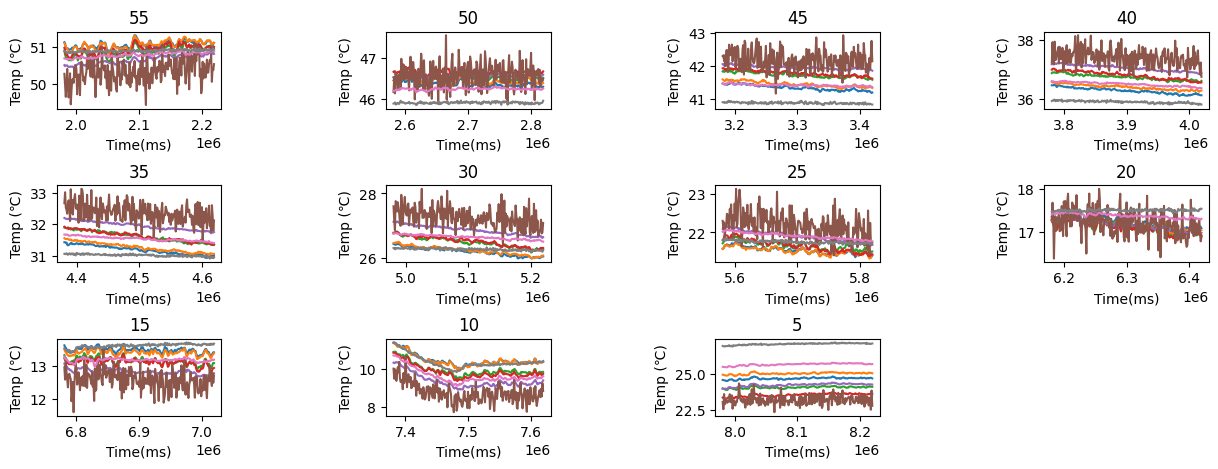

In [95]:
#calculate noise in temperature domain
conv_temp_dict = {}
conv_averaged_temp_dict = {}
conv_temp_dicts = []
avg_conv_temp_dict = {}
plt.figure()

conv_t_df = pd.DataFrame()
conv_averaged_temp_df = pd.DataFrame()
conv_ch_avg = pd.DataFrame()
conv_ch_std_dev = pd.DataFrame()

lower_bound = offset
#for each segmented temp data, convert voltage to temps and calculate mean/standard deviation
for chamber_temp in chamber_temps:
    conv_temp_dict = {}
    lower_bound += time_interval_ms #ignore first interval
    for i in range(0, temp_ranges.size):
        conv_temp_dict[str(temp_ranges[i])] = combined_data_temp[(combined_data_temp["Time(ms)"] > (lower_bound+begin_cutoff)) & (combined_data_temp["Time(ms)"] < (lower_bound + time_interval_ms-end_cutoff))]
        conv_temp_dict[str(temp_ranges[i])].insert(loc = 1,
            column = "BB Temp",
            value = temp_ranges[i])
        lower_bound += time_interval_ms

        #copy segmented temperature, perform rolling mean
        conv_temp_dict_copy = conv_temp_dict[str(temp_ranges[i])].copy()
        conv_averaged_temp_dict[str(temp_ranges[i])] = conv_temp_dict_copy[channel_col].rolling(window_size).mean()

        #re-add BB temp and time
        conv_averaged_temp_dict[str(temp_ranges[i])].insert(loc = 0,
            column = "BB Temp",
            value = temp_ranges[i])
        conv_averaged_temp_dict[str(temp_ranges[i])].insert(loc = 0,
            column = "Time(ms)",
            value = data["Time(ms)"])
        
        #drop the first few samples not in window
        conv_averaged_temp_dict[str(temp_ranges[i])].drop(conv_averaged_temp_dict[str(temp_ranges[i])].index[:window_size], inplace=True)

    conv_temp_dicts.append(conv_temp_dict)
    conv_temp_df = pd.concat(list(conv_temp_dict.values()))
    conv_temp_df.to_csv('Reports/' + file_name + '/' + str(chamber_temp) + '/' + str(chamber_temp) + '_temp_cleaned_' + file_name + '.csv')

    conv_averaged_temp_df = pd.concat(list(conv_averaged_temp_dict.values()))
    conv_averaged_temp_df.to_csv('Reports/' + file_name + '/' + str(chamber_temp) + '/' + str(chamber_temp) + '_temp_averaged_cleaned_' + file_name + '.csv')


temp_index = 0 
#for each BB temp, find the average and standard deviation of the recorded temperature
for conv_temp_dict in conv_temp_dicts:
    i = 1
    conv_ch_avgs = pd.DataFrame()
    conv_ch_std_dev = pd.DataFrame()
    plt.figure()
    for temp in conv_temp_dict: 
        temp_segment = conv_temp_dict[temp]
        conv_ch_avgs[temp] = temp_segment[channel_col].mean()
        conv_ch_std_dev[temp] = temp_segment[channel_col].std()
        max_temp = temp_segment.max() #get max temps

        min_temp = temp_segment.min() #get min temps 

        conv_tpp = max_temp - min_temp
        conv_tpp_df = pd.DataFrame({'TPP' + str(temp): conv_tpp}).T
        conv_t_df = pd.concat([conv_t_df, conv_tpp_df])
        ax = plt.subplot(3, 4, i)
        plt.subplots_adjust(left=0.1, right=1.9, bottom=0.1, top=0.9, wspace=1, hspace=1)

        plt.plot(temp_segment.loc[:,"Time(ms)"], temp_segment.loc[:,channel_col])
        plt.title(temp)
        plt.ylabel("Temp (\N{DEGREE CELSIUS})")
        plt.xlabel("Time(ms)")
        i += 1

    #add converted temp averages and std deviations to the dataframe and plot them
    conv_ch_avgs=conv_ch_avgs.T
    conv_ch_avgs.insert(loc = 0, column = 'Temp', value = temp_ranges)
    conv_ch_std_dev =conv_ch_std_dev.T
    conv_ch_std_dev.insert(loc = 0, column = 'Temp', value = temp_ranges)
    #display(conv_ch_avgs)
    display(conv_ch_std_dev)
    #display(conv_t_df)
    print(conv_ch_std_dev[channel_col].loc[(conv_ch_std_dev['Temp'] <= 40) & (conv_ch_std_dev['Temp'] >= 20)].mean().mean())
    conv_ch_avgs.to_csv('Reports/' + file_name + '/' + str(chamber_temps[temp_index]) + '/' + str(chamber_temps[temp_index]) + '_temp_avg_' + file_name + '.csv')
    conv_ch_std_dev.to_csv('Reports/' + file_name + '/' + str(chamber_temps[temp_index]) + '/' + str(chamber_temps[temp_index]) + '_temp_std_dev_' + file_name + '.csv')
    temp_index += 1
# -------------UNCOMMENT FOR AVERAGE MEASURED TEMPS vs BB TEMPS, REQUIRES BB TEMPS------------------#
""" for ch in channel_col:
    plt.scatter(temp_ranges, conv_ch_avgs[ch])
plt.xlabel("BB Temp. (\N{DEGREE CELSIUS})")
plt.ylabel("Average Recorded Temp. (\N{DEGREE CELSIUS})")
plt.title("Avg. Temp. vs. BB Temp")
plt.legend(channel_col, fontsize = 5)
plt.savefig('Reports/' + file_name + '/' + 'avg_temps_' + file_name + '.png', bbox_inches='tight') """
# -------------UNCOMMENT FOR AVERAGE MEASURED TEMPS vs BB TEMPS, REQUIRES BB TEMPS------------------#



Calculating Temperature to Radiance Curves

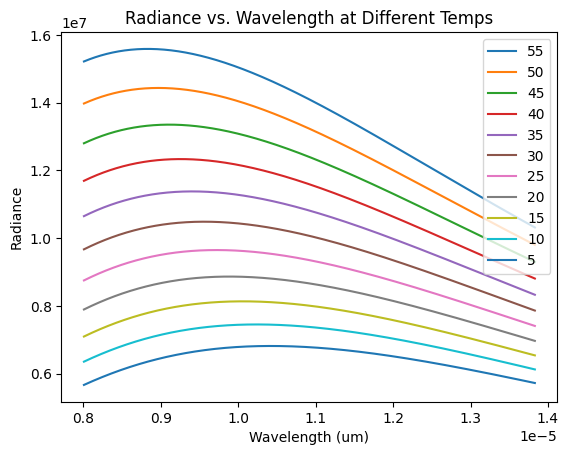

In [96]:
#units are watt/meter squared,

#read in response curve
dex = pd.read_csv("Data/dexter_filters.csv")
dex["Wavelength"] = dex["Wavelength"] * 1e-6
#normalize each channel by dividing by the max
dex_norm = dex
#chans = ['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8']
for ch in channel_col:
    dex_norm[ch] = dex[ch] / dex[ch].abs().max()

#display(dex_norm)


#use Planck radiance equation to obtain curves
planck = pd.DataFrame()
planck["Wavelength"] = dex_norm["Wavelength"]
plt.figure()
for temp in temp_ranges:
    planck[temp] = planck_radiance((planck["Wavelength"]), temp)
    plt.plot(planck["Wavelength"], planck[temp])
    plt.legend(temp_ranges)
    plt.title("Radiance vs. Wavelength at Different Temps")
    plt.xlabel("Wavelength (um)")
    plt.ylabel("Radiance")

be_radiance = pd.DataFrame()
be_radiance["Temperature"] = temp_ranges

#calculate BE radiance for each temperature at each channel
for ch in channel_col:
    radiance = []
    for temp in temp_ranges:
        numerator = 0
        for a, b in zip(planck[temp], dex_norm[ch]):
            numerator += a * b
        
        denominator = dex_norm[ch].sum()
        radiance.append(numerator/denominator)
    be_radiance[ch] = radiance

#display(be_radiance)



Plot radiance vs. time from data

,Time(ms),T1CA(v),T1CB(v),T1CC(v),T1CD(v),T1Therm(c),T2CA(v),T2CB(v),T2CC(v),T2CD(v),T2Therm(c)
0,877,1568.978649,1599.111474,1887.727063,2182.511692,24.187507,1338.387323,2000.873796,1046.829632,714.636215,23.350491
1,2006,1644.805977,1641.237115,1968.167098,2275.290735,24.225816,1368.065828,1991.444178,1056.758647,713.585495,23.359616
2,3135,1687.184024,1658.125044,2006.379642,2329.286532,24.223290,1383.915894,1991.842779,1061.499047,716.372008,23.356687
3,4264,1718.303197,1672.721772,2034.178872,2371.580868,24.221468,1404.257560,2050.226210,1069.771860,715.409221,23.355109
4,5393,1738.543103,1681.069074,2052.054244,2400.787827,24.221292,1415.818459,2037.252705,1072.014162,713.907339,23.354772
...,...,...,...,...,...,...,...,...,...,...,...
8157,9215577,1833.899603,1726.093226,1872.238730,2182.446695,29.780539,1382.734757,1745.781853,1221.359829,978.004039,28.904603
8158,9216706,1834.425975,1727.600961,1871.721435,2180.987049,29.780846,1382.119873,1747.063547,1221.545848,977.713874,28.905449
8159,9217835,1832.043197,1728.611272,1871.350810,2182.110605,29.782073,1382.207195,1767.427301,1220.989500,978.137752,28.905780
8160,9218964,1831.970293,1727.376662,1870.406404,2181.614954,29.782571,1381.411588,1721.027606,1221.262115,977.503625,28.906847


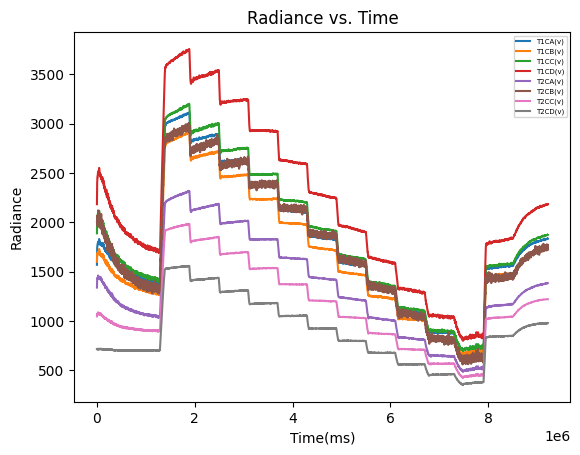

In [97]:
data_radiance = pd.DataFrame()
data_radiance = data.copy()
radiance_popt = {}
radiance_pcov = {}
plt.figure()
for chan in channel_col:
    #determine line of best fit for temperature to radiance function using lookup table, then convert temps using that line
    radiance_popt[chan], radiance_pcov[chan] = curve_fit(linear_fit, be_radiance["Temperature"], be_radiance[chan])
    temp_to_radiance = linear_fit(data_temp[chan], *temp_popt[chan] )
    data_radiance[chan] = temp_to_radiance
    plt.plot(data_temp["Time(ms)"], data_radiance[chan])
    plt.xlabel("Time(ms)")
    plt.ylabel("Radiance")
    plt.legend(channel_col, fontsize = 5)
plt.title("Radiance vs. Time")

plt.savefig('Reports/' + file_name + '/' + 'radiance_' + file_name + '.png', bbox_inches='tight')
display(data_radiance)

,Temp,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T2CA(v),T2CB(v),T2CC(v),T2CD(v)
55,55,3015.817199,2816.387522,3084.125895,3614.983493,2231.294690,2869.736058,1932.781130,1534.383108
50,50,2846.943092,2669.876909,2940.167443,3468.782912,2139.483836,2758.703214,1821.805594,1419.576152
45,45,2621.735401,2462.857045,2728.969125,3222.680762,1996.022736,2589.554993,1683.273628,1299.545874
40,40,2373.602601,2232.625962,2484.215868,2928.622718,1825.587674,2379.258857,1531.596959,1176.393736
35,35,2114.986914,1991.118774,2220.168637,2618.498910,1637.694860,2142.217276,1371.919193,1050.701548
30,30,1848.492577,1739.716242,1942.861914,2285.568108,1436.197858,1883.387985,1205.702453,923.738586
25,25,1582.298113,1487.933362,1659.273385,1953.157360,1231.883434,1615.534295,1039.408482,798.957906
20,20,1328.465600,1247.995784,1386.838556,1629.259044,1027.764715,1344.421891,874.640476,677.145428
15,15,1091.537751,1023.109860,1128.237591,1322.894078,830.411220,1075.127916,715.191547,561.376140
10,10,886.078761,830.002892,901.857041,1053.804875,650.500929,824.256252,567.093555,455.103700


,Temp,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T2CA(v),T2CB(v),T2CC(v),T2CD(v)
55,55,34.138991,32.818623,35.262061,46.501875,27.921282,33.988161,17.036721,7.874259
50,50,8.877735,9.477532,11.971707,12.394200,8.028973,19.986060,5.029200,2.798641
45,45,3.560016,4.088199,4.834752,6.314900,4.253651,16.706120,3.380787,2.486076
40,40,2.150460,2.191591,2.438441,2.152714,1.474301,16.390049,1.965687,1.811223
35,35,2.954260,2.190385,3.055736,6.301448,2.563622,15.562637,1.140825,0.849915
30,30,6.196554,6.261828,8.105085,7.920692,3.655654,16.262166,1.138740,0.930138
25,25,6.140300,5.763468,8.007404,8.482427,4.387783,16.504071,1.470162,0.828932
20,20,4.240172,3.791742,5.270369,10.160376,5.298799,18.023046,2.636929,1.011589
15,15,6.131391,5.484845,7.756375,7.360024,3.714995,16.213331,1.317881,1.075318
10,10,4.139553,3.805726,5.453710,6.913992,3.295691,16.408328,2.011175,2.107211


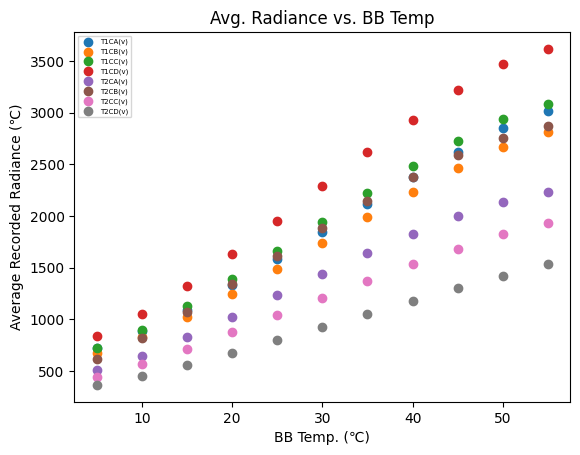

In [98]:
#calculate radiance in temperature domain (THIS PART IS WIP)
rad_dict = {}
plt.figure()

rad_ch_avgs = pd.DataFrame()
rad_ch_std_dev = pd.DataFrame()
lower_bound = offset
#for each segmented temp data, convert voltage to temps and calculate mean/standard deviation
for i in range(0, temp_ranges.size):
    rad_dict[str(temp_ranges[i])] = data_radiance[(data_radiance["Time(ms)"] > (lower_bound+begin_cutoff)) & (data_radiance["Time(ms)"] < (lower_bound + time_interval_ms-end_cutoff))]
    lower_bound += time_interval_ms

#for each BB temp, find the average and standard deviation of the recorded temperature
for rad in rad_dict:
    rad_segment = rad_dict[rad]
    rad_ch_avgs[rad] = rad_segment[channel_col].mean()
    rad_ch_std_dev[rad] = rad_segment[channel_col].std()

#calculate averages/standard deviations for radiance
rad_ch_avgs=rad_ch_avgs.T
rad_ch_avgs.insert(loc = 0, column = 'Temp', value = temp_ranges)
rad_ch_std_dev =rad_ch_std_dev.T
rad_ch_std_dev.insert(loc = 0, column = 'Temp', value = temp_ranges)
display(rad_ch_avgs)
display(rad_ch_std_dev)
for ch in channel_col:
    plt.scatter(temp_ranges, rad_ch_avgs[ch])
plt.xlabel("BB Temp. (\N{DEGREE CELSIUS})")
plt.ylabel("Average Recorded Radiance (\N{DEGREE CELSIUS})")
plt.title("Avg. Radiance vs. BB Temp")
plt.legend(channel_col, fontsize = 5)